In [1]:
import xarray as xr
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
import wrf as wrfpy
from optwrf import plots
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import numpy as np

No module named 'pyresample'


In [2]:
# Open data from the full loop that I ran previously 
fx = xr.open_dataarray('../data/quantiles.nc')

In [3]:
wrfds = xr.open_dataset('/share/mzhang/jas983/wrf_data/met4ene/wrfout/ARW/offshore_wind/no_wfp/2020-02-04_28mp4lw4sw2lsm5pbl1cu/ow_wrfout_d03_2020-02-04-2020-02-12')

# Get the start_date and create the date string
datestr = str(wrfds.Time.dt.strftime('%Y-%m-%d %H:%M')[0].values)

# To start, we need to get the WRF map projection information (a Lambert Conformal grid),
# and find the domain boundaries in this projection.
# NOTE: this task MUST occurr before we regrid the WRF variables or the coordinates change and become incompatible.
wrf_cartopy_proj = plots.get_wrf_proj(wrfds, 'temp')
proj_bounds = plots.get_domain_boundary(wrfds, wrf_cartopy_proj)

Variables {'lat': 'XLAT', 'lon': 'XLONG'} cannot be renamed, those on the left are not in this dataset.


/home/jas983/anaconda3/envs/enspp/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'pressure' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [36]:
p = 90
plot_var = fx.sel(Step_index=0, Percentile=p).reset_coords('Step_index', drop=True).squeeze()

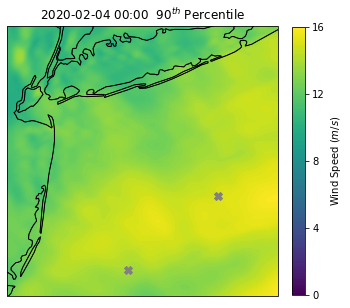

In [37]:
# Set the figure size
fig = plt.figure(figsize=(6, 6))
# Set the GeoAxes to the projection used by WRF
ax_wrf = fig.add_subplot(1, 1, 1, projection=wrf_cartopy_proj)
# Plot the 10th percentile wind speed across the domain
cn = ax_wrf.contourf(wrfpy.to_np(fx.XLONG), wrfpy.to_np(fx.XLAT), wrfpy.to_np(plot_var),
                np.linspace(0, 16, 121), transform=ccrs.PlateCarree(), cmap='viridis')

# Plot the buoy locations
ax_wrf.plot(-72.716692, 39.969278, transform=ccrs.PlateCarree(), markersize=8, marker='X', color='grey')
ax_wrf.plot(-73.428892, 39.546772, transform=ccrs.PlateCarree(), markersize=8, marker='X', color='grey')

# Format the projected bounds so they can be used in the xlim and ylim attributes
proj_xbounds = [proj_bounds[0, 0], proj_bounds[1, 0]]
proj_ybounds = [proj_bounds[0, 1], proj_bounds[1, 1]]

# Finally, set the x and y limits
ax_wrf.set_xlim(proj_xbounds)
ax_wrf.set_ylim(proj_ybounds)

# Download and add the states, coastlines, and lakes
shapename = 'admin_1_states_provinces_lakes'
states_shp = shpreader.natural_earth(resolution='10m',
                                     category='cultural', 
                                     name=shapename)
# Add features to the maps
ax_wrf.add_geometries(
        shpreader.Reader(states_shp).geometries(),
        ccrs.PlateCarree(),
        facecolor='none',
        linewidth=.5, 
        edgecolor="black"
        )
ax_wrf.add_feature(cfeature.COASTLINE)

# Add color bars
cbar_ticks=(0, 4, 8, 12, 16)
cbar_tick_labels=[0, 4, 8, 12, 16]
cbar = plt.colorbar(cn,
                    ax=ax_wrf,
                    ticks=cbar_ticks,
                    shrink=0.82,
                    pad=0.04,
                    label='Wind Speed ($m/s$)'
                    )
cbar.ax.set_yticklabels(cbar_tick_labels)  # vertically oriented colorbar

# Add the axis title
tex = '$^{th}$'
ax_wrf.set_title(f'{datestr}  {p}{tex} Percentile', fontsize=12)

plt.savefig(f'../data/plots/quantile_map_{p}_{datestr}.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

In [ ]:
# Plot the 10th percentile wind speed across the domain
p = fx.sel(Step_index=0, Percentile=50).reset_coords('Step_index', drop=True).plot(
    transform=wrf_cartopy_proj,  # the data's projection,
    subplot_kws={"projection": ccrs.PlateCarree()},
    vmin=0,
    vmax=16,
    )
# states = cfeature.NaturalEarthFeature(category="cultural", scale="110m",
#                                        facecolor="none",
#                                        name="admin_1_states_provinces_shp")
ax = p.axes
ax.coastlines()
# ax.add_feature(states, linewidth=.5, edgecolor="black")

In [ ]:
# Plot the 90th percentile wind speed across the domain
# Plot the 10th percentile wind speed across the domain
p = fx.sel(Step_index=0, Percentile=90).reset_coords('Step_index', drop=True).plot(
    # transform=ccrs.PlateCarree(),  # the data's projection,
    subplot_kws={"projection": wrf_cartopy_proj},
    vmin=0,
    vmax=16,
    )
# states = cfeature.NaturalEarthFeature(category="cultural", scale="110m",
#                                        facecolor="none",
#                                        name="admin_1_states_provinces_shp")
ax = p.axes
ax.coastlines()
# ax.add_feature(states, linewidth=.5, edgecolor="black")

In [ ]:
p = plot_var.plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    # col="time",
    # col_wrap=1,  # multiplot settings
    # aspect=wrfds.dims["west_east"] / wrfds.dims["south_north"],  # for a sensible figsize
    subplot_kws={"projection": wrf_cartopy_proj},
)  # the plot's projection


# Format the plot
proj_xbounds = [proj_bounds[0, 0], proj_bounds[1, 0]]
proj_ybounds = [proj_bounds[0, 1], proj_bounds[1, 1]]


# We have to set the map's options on all axes
for ax in p.axes.flat:
    ax.coastlines()
    # Finally, set the x and y limits
    ax.set_xlim(proj_xbounds)
    ax.set_ylim(proj_ybounds)
    # ax.set_extent([-160, -30, 5, 75])

In [ ]:
# Now, get the desired variables
# Format the times for title slides
times_strings_f = wrfds.Time.dt.strftime('%b %d, %Y %H:%M')

timestr = wrfds.Time[0].values

In [ ]:
fx

In [ ]:
# WRF Variable
plot_var = fx.sel(Step_index=0, Percentile=10).squeeze()

In [ ]:
# Create a figure
fig = plt.figure(figsize=(4, 4))

# Set the GeoAxes to the projection used by WRF
axis = fig.add_subplot(1, 1, 1, projection=wrf_cartopy_proj)

# Add the filled contour levels
color_map = get_cmap("Greens")

cn = axis.contourf(wrfpy.to_np(wrfds.XLONG), wrfpy.to_np(wrfds.XLAT), wrfpy.to_np(plot_var),
                 np.linspace(0, 20, 21), transform=ccrs.PlateCarree(), cmap=color_map)

# Format the plot
proj_xbounds = [proj_bounds[0, 0], proj_bounds[1, 0]]
proj_ybounds = [proj_bounds[0, 1], proj_bounds[1, 1]]

# Finally, set the x and y limits
axis.set_xlim(proj_xbounds)
axis.set_ylim(proj_ybounds)

# Download and add the states, coastlines, and lakes
# states = cfeature.NaturalEarthFeature(category="cultural", scale="50m",
#                                       facecolor="none",
#                                       name="admin_1_states_provinces_shp")

# Add features to the maps
# axis.add_feature(states, linewidth=.5, edgecolor="black")
axis.add_feature(cfeature.LAKES.with_scale('50m'), alpha=0.9)
axis.add_feature(cfeature.OCEAN.with_scale('50m'))

# Add color bars
cbar = plt.colorbar(cn,
                    ax=axis,
                    ticks=(0, 3, 6, 9, 12, 15, 18, 21),
                    shrink=0.46,
                    pad=0.05
                    )
# if cbar_tick_labels is not None:
#     cbar.ax.set_yticklabels(cbar_tick_labels)  # vertically oriented colorbar

# Add the axis title
axis.set_title('title_str', fontsize=10)

# Save the figure(s)
# if save_fig:
#     file_type = kwargs.get('file_type', '.pdf')
#     plt.savefig(fig_path + file_type, dpi=300, transparent=True, bbox_inches='tight')

plt.show()